In [1]:
# If you have compiled Mitsuba 3 yourself, you will need to specify the path
# to the compilation folder
# import sys
# sys.path.insert(0, '<mitsuba-path>/mitsuba3/build/python')
import mitsuba as mi
# To set a variant, you need to have set it in the mitsuba.conf file
# https://mitsuba.readthedocs.io/en/latest/src/key_topics/variants.html
print(mi.variants())
mi.set_variant('cuda_ad_rgb')

import mitransient as mitr

print('Using mitsuba version:', mi.__version__)
print('Using mitransient version:', mitr.__version__)

['scalar_rgb', 'scalar_spectral', 'scalar_spectral_polarized', 'llvm_ad_rgb', 'llvm_ad_mono', 'llvm_ad_mono_polarized', 'llvm_ad_spectral', 'llvm_ad_spectral_polarized', 'cuda_ad_rgb', 'cuda_ad_mono', 'cuda_ad_mono_polarized', 'cuda_ad_spectral', 'cuda_ad_spectral_polarized']
Using mitsuba version: 3.7.0
Using mitransient version: 1.2.0


In [2]:
import drjit as dr
import numpy as np

def get_rays_mitsuba(H, W, fx, fy, cx, cy, c2w_matrix):
    """
    Generate camera rays using DrJit/Mitsuba instead of PyTorch.
    
    Args:
        H, W: Image height and width
        fx, fy: Focal lengths
        cx, cy: Principal point coordinates
        c2w_matrix: Camera-to-world transformation matrix (4x4 numpy array)
    
    Returns:
        origins: Ray origins (H, W, 3) numpy array
        viewdirs: Ray directions (H, W, 3) numpy array
    """
    # Create pixel coordinates
    num_pixels = H * W
    idx = np.arange(num_pixels)
    x = idx % W
    y = idx // W
    
    # Convert to image coordinates with pixel centers
    # Using the same convention as the torch code: (x - cx + 0.5) / fx
    pixel_x = (x - cx + 0.5) / fx
    pixel_y = (y - cy + 0.5) / fy * -1.0  # Flip Y axis
    
    # Create direction vectors in camera space
    # Format: [pixel_x, pixel_y, -1.0] (pointing into the scene)
    dirs_camera = np.stack([pixel_x, pixel_y, np.full(num_pixels, -1.0)], axis=-1)
    
    # Extract rotation and translation from c2w matrix
    rotation = c2w_matrix[:3, :3]
    translation = c2w_matrix[:3, 3]
    
    # Transform directions to world space
    directions = dirs_camera @ rotation.T  # (num_pixels, 3) @ (3, 3).T
    
    # Normalize directions
    directions = directions / np.linalg.norm(directions, axis=-1, keepdims=True)
    
    # Broadcast camera origin to all rays
    origins = np.broadcast_to(translation, (num_pixels, 3))
    
    # Reshape to image dimensions
    origins = origins.reshape(H, W, 3)
    viewdirs = directions.reshape(H, W, 3)
    
    # Negate viewdirs to match torch convention
    viewdirs = -1 * viewdirs
    
    return origins, viewdirs

d = mitr.cornell_box()

In [3]:
import numpy as np

# Image dimensions
H, W = 255, 255
fov = 0.69097585

# Compute camera intrinsics
fx = (W / 2.0) / np.tan(fov / 2.0)
fy = fx
cx = float(W) / 2.0
cy = float(H) / 2.0

# Get camera-to-world matrix from the sensor
c2w_transform = d['sensor']['to_world']
c2w_matrix = np.array(c2w_transform.matrix)

# Generate rays using Mitsuba/DrJit approach
origins, rays = get_rays_mitsuba(H, W, fx, fy, cx, cy, c2w_matrix)

print(f"Origins shape: {origins.shape}")
print(f"Rays shape: {rays.shape}")
print(f"Sample ray direction at (0,0): {rays[0, 0]}")
print(f"Sample ray origin at (0,0): {origins[0, 0]}")

Origins shape: (255, 255, 3)
Rays shape: (255, 255, 3)
Sample ray direction at (0,0): [-0.31976103 -0.31976101 -0.89191131]
Sample ray origin at (0,0): [0.  0.  3.9]


Parametric projector created:
  Grid size: 1 rows x 3 cols = 3 spots
  Gaussian sigma (normalized): 0.001
  Intensity per spot: 33333.333333333336 (base: 100000.0)
  Samples per pixel: 30000 (base: 10000)
  Max rejection samples: 4
  Spot positions:
[[-0.66666667  0.        ]
 [ 0.          0.        ]
 [ 0.66666667  0.        ]]


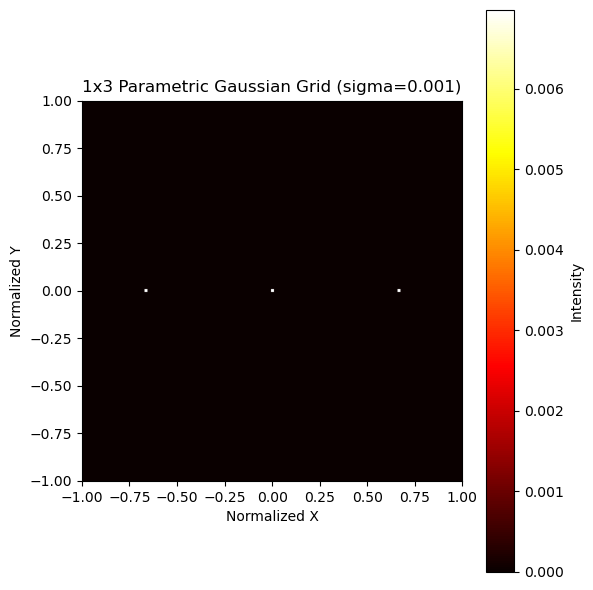

In [4]:
# Create parametric projector with Gaussian spots
import numpy as np

def create_parametric_grid(grid_rows, grid_cols, sigma, intensity, spacing='uniform', random_seed=None):
    """
    Create parametric projector parameters for a grid of Gaussian spots.
    
    Args:
        grid_rows: Number of Gaussians along Y dimension
        grid_cols: Number of Gaussians along X dimension
        sigma: Standard deviation of each Gaussian in normalized coordinates [-1, 1]
        intensity: Intensity of each spot (RGB)
        spacing: 'uniform' for evenly spaced grid, 'random' for random positions
        random_seed: Random seed for reproducible random positions
    
    Returns:
        positions: Nx2 array of spot positions in normalized coordinates [-1, 1]
        sigmas: N-element array of standard deviations
        intensities: Nx3 array of RGB intensities
    """
    if spacing == 'uniform':
        # Create uniformly spaced grid in normalized coordinates [-1, 1]
        margin_x = (1.0 / grid_cols if grid_cols > 1 else 0.0)
        margin_y = (1.0 / grid_rows if grid_rows > 1 else 0.0)
        x_positions = np.linspace(-1 + margin_x, 1 - margin_x, grid_cols) if grid_cols > 1 else np.array([0.0])
        y_positions = np.linspace(-1 + margin_y, 1 - margin_y, grid_rows) if grid_rows > 1 else np.array([0.0])
        
        # Create all combinations
        xx, yy = np.meshgrid(x_positions, y_positions)
        positions = np.stack([xx.flatten(), yy.flatten()], axis=-1)
        
    elif spacing == 'random':
        if random_seed is not None:
            np.random.seed(random_seed)
        
        num_spots = grid_rows * grid_cols
        margin = 3 * sigma
        positions = np.random.uniform(-1 + margin, 1 - margin, (num_spots, 2))
    else:
        raise ValueError(f"Unknown spacing mode: {spacing}. Use 'uniform' or 'random'.")
    
    num_spots = positions.shape[0]
    sigmas = np.full(num_spots, sigma)
    intensities = np.full((num_spots, 3), intensity)
    
    return positions, sigmas, intensities

# ==== CONFIGURABLE PARAMETERS ====
grid_rows = 1  # Number of spots along Y
grid_cols = 3  # Number of spots along X
sigma = 0.001   # Standard deviation in normalized coordinates [-1, 1]
spacing_mode = 'uniform'  # 'uniform' or 'random'
random_seed = 42  # Only used if spacing_mode='random'
base_intensity = 100000.0  # Base intensity (will be divided by num_spots)
base_spp = 10000  # Base samples per pixel (will be multiplied by num_spots)
max_rejection_samples = 4  # Max rejection sampling iterations for out-of-FOV samples
fov = 0.55

num_spots = grid_rows * grid_cols
intensity = base_intensity / num_spots  # Divide intensity by number of spots
spp = base_spp * num_spots  # Scale samples by number of spots

# Create parametric projector parameters
spot_positions, spot_sigmas, spot_intensities = create_parametric_grid(
    grid_rows=grid_rows,
    grid_cols=grid_cols,
    sigma=sigma,
    intensity=intensity,
    spacing=spacing_mode,
    random_seed=random_seed
)

print(f"Parametric projector created:")
print(f"  Grid size: {grid_rows} rows x {grid_cols} cols = {num_spots} spots")
print(f"  Gaussian sigma (normalized): {sigma}")
print(f"  Intensity per spot: {intensity} (base: {base_intensity})")
print(f"  Samples per pixel: {spp} (base: {base_spp})")
print(f"  Max rejection samples: {max_rejection_samples}")
print(f"  Spot positions:\n{spot_positions}")

# Visualize the parametric pattern
import matplotlib.pyplot as plt

def visualize_parametric_projector(positions, sigmas, intensities, resolution=256):
    """Visualize the parametric projector pattern."""
    x = np.linspace(-1, 1, resolution)
    y = np.linspace(-1, 1, resolution)
    xx, yy = np.meshgrid(x, y)
    
    pattern = np.zeros((resolution, resolution))
    for i in range(len(sigmas)):
        cx, cy = positions[i]
        s = sigmas[i]
        intensity_val = intensities[i, 0]
        dist_sq = (xx - cx)**2 + (yy - cy)**2
        gaussian = intensity_val * np.exp(-dist_sq / (2 * s**2))
        pattern += gaussian
    
    return pattern

pattern = visualize_parametric_projector(spot_positions, spot_sigmas, spot_intensities)

plt.figure(figsize=(6, 6))
plt.imshow(pattern, cmap='hot', extent=[-1, 1, -1, 1], origin='lower')
plt.colorbar(label='Intensity')
plt.title(f'{grid_rows}x{grid_cols} Parametric Gaussian Grid (sigma={sigma})')
plt.xlabel('Normalized X')
plt.ylabel('Normalized Y')
plt.tight_layout()
plt.show()

In [7]:
# Remove keys from a list
keys_to_remove = ['light', 'integrator']  # Example: remove these plugins if present
for k in keys_to_remove:
    d.pop(k, None)

# Update film parameters for batch rendering
d['sensor']['film']['temporal_bins'] = 1000
d['sensor']['film']['width'] = W
d['sensor']['film']['height'] = H
print(d['sensor'])

# Build projector frame aligned with camera
# Extract camera forward direction from the camera-to-world transform
# The camera looks down -Z in camera space, so forward is -column[2] in world space
camera_transform_matrix = c2w_matrix[:3, :3]  # 3x3 rotation part
camera_forward = -camera_transform_matrix[:, 2]  # Camera looks down -Z, so forward is -Z column
camera_up = np.array([0.0, 1.0, 0.0])
camera_right = np.cross(camera_forward, camera_up)
camera_right = camera_right / np.linalg.norm(camera_right)
camera_up = np.cross(camera_right, camera_forward)
camera_up = camera_up / np.linalg.norm(camera_up)

# Build projector frame as 3x3 matrix with columns [right, up, forward]
projector_frame_np = np.vstack([camera_right, camera_up, camera_forward])
projector_frame = mi.Matrix3f(projector_frame_np)

print(f"\nProjector frame (columns: right, up, forward):")
print(f"  Right:   {camera_right}")
print(f"  Up:      {camera_up}")
print(f"  Forward: {camera_forward}")

# Setup integrator - use the parametric projector model
integrator = mi.load_dict(
    {
        "type": "transient_path",
        "temporal_filter": "gaussian",
        "gaussian_stddev": 4.0,
        "use_confocal_light_source": False,  # Set to False to use static projector frame
        "use_nlos_only": False,
        "camera_unwarp": True,
        "projector_fov": fov,
        "projector_frame": projector_frame,
        # Parametric projector parameters
        "projector_spot_positions": mi.TensorXf(spot_positions),
        "projector_spot_sigmas": mi.TensorXf(spot_sigmas),
        "projector_spot_intensities": mi.TensorXf(spot_intensities),
        "max_rejection_samples": max_rejection_samples,
    }
)
d['integrator'] = integrator

print(f"\nScene created successfully!")
print(f"Using parametric projector: {grid_rows}x{grid_cols} grid, sigma={sigma}")
print(f"Number of spots: {num_spots}")
print(f"Samples per pixel: {spp}")
print(f"Max rejection samples: {max_rejection_samples}")
print(f"Projector frame mode: {'Confocal (dynamic)' if integrator.use_confocal_light_source else 'Static (camera-aligned)'}")

scene = mi.load_dict(d)
data_steady, data_transient = mi.render(scene, spp=spp)

{'type': 'perspective', 'fov_axis': 'smaller', 'near_clip': 0.001, 'far_clip': 100.0, 'focus_distance': 1000, 'fov': 39.3077, 'to_world': Transform[
  matrix=[[-1, 0, 0, 0],
          [0, 1, 0, 0],
          [0, 0, -1, 3.9],
          [0, 0, 0, 1]],
  inverse_transpose=[[-1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, -1, 0],
                     [0, 0, 3.9, 1]]
], 'sampler': {'type': 'independent', 'sample_count': 256}, 'film': {'type': 'transient_hdr_film', 'width': 255, 'height': 255, 'rfilter': {'type': 'box'}, 'temporal_bins': 1000, 'start_opl': 3.5, 'bin_width_opl': 0.02}}

Projector frame (columns: right, up, forward):
  Right:   [-1.  0.  0.]
  Up:      [0. 1. 0.]
  Forward: [-0.         -0.          0.99999994]

Scene created successfully!
Using parametric projector: 1x3 grid, sigma=0.001
Number of spots: 3
Samples per pixel: 30000
Max rejection samples: 4
Projector frame mode: Static (camera-aligned)


nanobind: implicit conversion from type 'TensorXf' to type 'drjit.scalar.Array3f64' failed!
nanobind: implicit conversion from type 'TensorXf' to type 'mitsuba.ScalarColor3f' failed!
nanobind: implicit conversion from type 'TensorXf' to type 'mitsuba.ScalarColor3d' failed!
nanobind: implicit conversion from type 'TensorXf' to type 'drjit.scalar.Array3f64' failed!
nanobind: implicit conversion from type 'TensorXf' to type 'mitsuba.ScalarColor3f' failed!
nanobind: implicit conversion from type 'TensorXf' to type 'mitsuba.ScalarColor3d' failed!
nanobind: implicit conversion from type 'TensorXf' to type 'drjit.scalar.Array3f64' failed!
nanobind: implicit conversion from type 'TensorXf' to type 'mitsuba.ScalarColor3f' failed!
nanobind: implicit conversion from type 'TensorXf' to type 'mitsuba.ScalarColor3d' failed!


In [8]:
# Plot the computed transient image as a video
data_transient_clipped = dr.clip(data_transient, 0.0, 1.0)
data_transient_tonemapped = mitr.vis.tonemap_transient(data_transient_clipped)

mitr.vis.save_video(
    'stupid.mp4',
    data_transient_tonemapped,
    axis_video=2,
)

0.10305938


In [ ]:
# Plot some frames of the computed transient image
import matplotlib.pyplot as plt

data_transient_tonemapped[data_transient_tonemapped > 1] = 1

plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(data_transient_tonemapped[:, :, 100])  # frame 100 (video has 300 frames)
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(data_transient_tonemapped[:, :, 140])  # frame 140 (video has 300 frames)
plt.show()